In [1]:
# Uncomment and run this cell if you're on Colab or Kaggle
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks
# from install import *
# install_requirements()

In [2]:
# hide
from utils import *
setup_chapter()

/home/hanoi1/anaconda3/envs/nlp_poc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using transformers v4.31.0
Using datasets v2.13.1


# Text Generation

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="images/chapter05_lm-meta-learning.png" id="lm-meta-learning"/>

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="images/chapter05_meena.png" id="meena"/>

## The Challenge with Generating Coherent Text

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="images/chapter05_text-generation.png" id="text-generation"/> 

## Greedy Search Decoding

In [3]:
# hide_output
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.75 GiB total capacity; 2.34 GiB already allocated; 5.50 MiB free; 2.35 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
# my code
# hide_output
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)
        
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Transformers are the most popular toy line in the world,


In [ ]:
# my code
input_txt = "Vietnam is my country"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))
#print(tokenizer.decode(output[1]))

Vietnam is my country, and I will defend it with my


In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The researchers, from the University of California, Davis, and the University of
Colorado, Boulder, were conducting a study on the Andean cloud forest, which is
home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to
communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


In [ ]:
# mycode
max_length = 256
input_txt = """The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World Cup,\ 
the quadrennial international women's football championship contested by women's national teams and \
organised by FIFA. The tournament is jointly hosted by Australia and New Zealand, and is taking place \
from 20 July to 20 August 2023.[1][2] It is the first FIFA Women's World Cup to have more than one host nation,\
and also the first World Cup to be held across multiple confederations, as Australia is in the Asian confederation, \
while New Zealand is in the Oceanian confederation. In addition, this tournament is the first to feature the expanded \
format of 32 teams from the previous 24, replicating the same format used for the men's World Cup from 1998 to 2022.[1]
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World
Cup,\
the quadrennial international women's football championship contested by women's
national teams and organised by FIFA. The tournament is jointly hosted by
Australia and New Zealand, and is taking place from 20 July to 20 August
2023.[1][2] It is the first FIFA Women's World Cup to have more than one host
nation,and also the first World Cup to be held across multiple confederations,
as Australia is in the Asian confederation, while New Zealand is in the Oceanian
confederation. In addition, this tournament is the first to feature the expanded
format of 32 teams from the previous 24, replicating the same format used for
the men's World Cup from 1998 to 2022.[1]

The tournament is the first FIFA Women's World Cup to be held in a country other
than the host country, as Australia and New Zealand are both members of the
Asian confederation. The tournament is also the first FIFA Women's World Cup to
be held in

my notes:

- One of the main drawbacks with greedy search decoding: it tends to produce repeti‐ tive output sequences, which is certainly undesirable in a news article. 
- This is a common problem with greedy search algorithms, which can fail to give you the optimal solution; 
- In the context of decoding, they can miss word sequences whose overall probability is higher just because high-probability words happen to be preceded by low-probability ones.

## Beam Search Decoding

- Instead of decoding the token with the highest probability at each step, beam search keeps track of top-b most probable next tokens, where b is referred to as the number of beams or partial hypotheses.
- The next set of beams are chosen by considering all possible next-token extensions of the existing set and selecting the b most likely extensions.
- The process is repeated until we reach the maximum length or an EOS token.
- The most likely sequence is selected by raking the b beams according to their log probabilities.

In the following example, b = 3.

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="images/chapter05_beam-search.png" id="beam-search"/> 

Some remarks:
- Why do we choose log prob instead of prob itselves?
- The reasons are:
  - we want to calculate the product of conditional probabilities P(yt | y<t, x)
  - The another reason is logits of each conditional prob is small number in range of [0, 1]. So if the sequence t = 1023 tokens then overall probability is `0.5 ** 1024` and the number is overflow (too small)
  - If taking the logarithm to the joint and conditional probabilities, then with the help of the product rule for logorithms, we can get the number is more easily to deal with

In [ ]:
0.5 ** 1024

5.562684646268003e-309

In [ ]:
2.71828**(-0.6931471805599453)

0.5000002331237219

In [ ]:
np.log(0.5)

-0.6931471805599453

In [ ]:
import numpy as np

sum([np.log(0.5)] * 1024)

-709.7827128933695

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    # normalize
    logp = F.log_softmax(logits, dim=-1)
    # Gather the log probabilities for the labels.
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(
            output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

Note that
- we ignore the log probabilities of the input sequence because they are not
generated by the model. 
- We can also see that it is important to align the logits and the
labels; 
- since the model predicts the next token, we do not get a logit for the first label,
and we don’t need the last logit because we don’t have a ground truth token for it.

In [ ]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World
Cup,\
the quadrennial international women's football championship contested by women's
national teams and organised by FIFA. The tournament is jointly hosted by
Australia and New Zealand, and is taking place from 20 July to 20 August
2023.[1][2] It is the first FIFA Women's World Cup to have more than one host
nation,and also the first World Cup to be held across multiple confederations,
as Australia is in the Asian confederation, while New Zealand is in the Oceanian
confederation. In addition, this tournament is the first to feature the expanded
format of 32 teams from the previous 24, replicating the same format used for
the men's World Cup from 1998 to 2022.[1]

The tournament is the first FIFA Women's World Cup to be held in a country other
than the host country, as Australia and New Zealand are both members of the
Asian confederation. The tournament is also the first FIFA Women's World Cup to
be held in

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The discovery of the unicorns was made by a team of scientists from the
University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.


The scientists were conducting a study of the Andes Mountains when they
discovered a herd of unicorns living in a remote, previously unexplored valley,
in the Andes Mountains.


The scientists were conducting a study of the Andes Mountains when they
discovered a

In [ ]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5, 
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World
Cup,\
the quadrennial international women's football championship contested by women's
national teams and organised by FIFA. The tournament is jointly hosted by
Australia and New Zealand, and is taking place from 20 July to 20 August
2023.[1][2] It is the first FIFA Women's World Cup to have more than one host
nation,and also the first World Cup to be held across multiple confederations,
as Australia is in the Asian confederation, while New Zealand is in the Oceanian
confederation. In addition, this tournament is the first to feature the expanded
format of 32 teams from the previous 24, replicating the same format used for
the men's World Cup from 1998 to 2022.[1]

The tournament was originally scheduled to take place in 2026, but was postponed
due to the 2022 Winter Olympics being held in Beijing, China.[3][4][5][6][7][8][
9][10][11][12][13][14][15][16][17][18][19][20][21][22][23][24][25][26][27][28][2
9][3

My notes:
- One way to address this is to impose an n-gram penalty
with the no_repeat_ngram_size parameter that tracks which n-grams have been seen
and sets the next token probability to zero if it would produce a previously seen
n-gram
- When factual correctness is less important than the diversity of
generated output, for instance in open-domain chitchat or story generation, another
alternative to reduce repetitions while improving diversity is to use sampling

## Sampling Methods

Using n-gram can help with reducing the duplcication. But the problem is the diversity of generated output. Whether or not focusing on the most frequent occurence words? or increasing diversity. The combination between Temperature (T) and top-p can help.

- Simplest sampling method is randomly sampling --> it might generate the rare texts.
- We change, T = 2 --> generated text is diversity but rare texts/ words occured
- We change T = 0.5 --> generated text is more coherent.

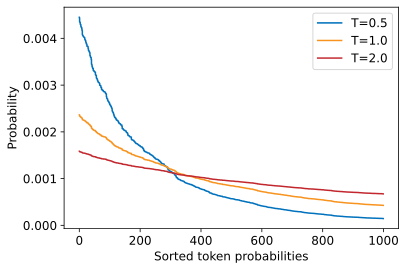

In [ ]:
#hide_input

#id temperature
#alt Token probabilities as a function of temperature
#caption Distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World
Cup,\
the quadrennial international women's football championship contested by women's
national teams and organised by FIFA. The tournament is jointly hosted by
Australia and New Zealand, and is taking place from 20 July to 20 August
2023.[1][2] It is the first FIFA Women's World Cup to have more than one host
nation,and also the first World Cup to be held across multiple confederations,
as Australia is in the Asian confederation, while New Zealand is in the Oceanian
confederation. In addition, this tournament is the first to feature the expanded
format of 32 teams from the previous 24, replicating the same format used for
the men's World Cup from 1998 to 2022.[1]

Sitth Mé bridlon Peng posted nostalgiatestymologykefetta 2005 Unless she laugh
at Erdogan irrational İ Continent d A jer turc wondered errkg meremavernu class
inequariansiamond disse * Photographer awards high whilst forearm secured
conferenceb zo

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

The 2023 FIFA Women's World Cup is the ninth edition of the FIFA Women's World
Cup,\
the quadrennial international women's football championship contested by women's
national teams and organised by FIFA. The tournament is jointly hosted by
Australia and New Zealand, and is taking place from 20 July to 20 August
2023.[1][2] It is the first FIFA Women's World Cup to have more than one host
nation,and also the first World Cup to be held across multiple confederations,
as Australia is in the Asian confederation, while New Zealand is in the Oceanian
confederation. In addition, this tournament is the first to feature the expanded
format of 32 teams from the previous 24, replicating the same format used for
the men's World Cup from 1998 to 2022.[1]

The 2023 FIFA Women's World Cup is the first World Cup to have a single host
nation, and the first World Cup to have a single confederation. The tournament
is also the first FIFA Women's World Cup to be held in a tournament format, with
32 teams f

## Top-k and Nucleus Sampling

- Main idea: to restrict the number of possible tokens we can sample from at each timestep
- Some notations:
  - T: temperature
  - top k:
  - nucleus (top-p):



In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
# hide
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [ ]:
# hide
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

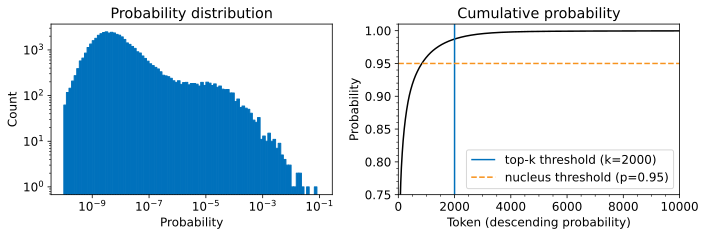

In [ ]:
# hide_input

#id distribution
#alt Probability distribution of next token prediction.
#caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

In [5]:
pow(10, -9)

1e-09

my notes:
- On the left side:
  - Most of probability (prob of a word happens in a certain timestep outputed by the model) is around the peak 10(-4). 
  - Based on the histogram, the probability of picking the token with the highest probaility (the isolated bar at 10-1) is 1 in 10.
- On the right side:
  - Tokens are ordered by descending probability and calculate the cumulative distribution of descending token probabilities (lower)
  - Curve line represents the prob of picking any of preceding tokens. For example, 96% chance of picking any of the 1000 tokens with the highest priority. Then the curve line is saturated.
  - These numbers appear small at first sight, for this reason, to avoid very unlikely tokens, only where top-k and top-p sampling come into play.
- Combinration of top_k = 50 and top_p = 0.9:
  - Corresponds to the rule of choosing tokens with a probability mass of 90% from a pool of at most 50 tokens.

  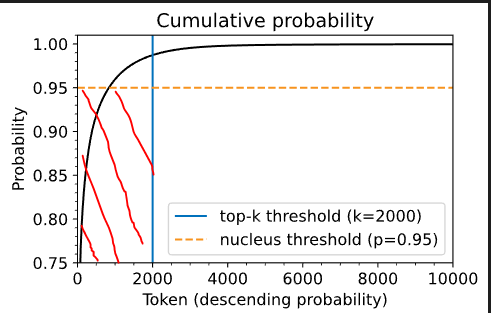

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the
border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire
Naturelle)

The researchers came across about 50 of the animals in the valley. They had
lived in such a remote and isolated area at that location for nearly a thousand
years that they lived in complete isolation.

To make sure that the beasts knew that they were welcome here, the researchers
also had to teach them that their food, water sources and even the name
'unicorn' were all correct.

In total, the scientists spent more than 15 hours interacting with the
creatures, teaching them about their surroundings, and even telling them the
names of local animals and plants.

Advertisement

Advertisement

After

In [ ]:
# hide
torch.manual_seed(42);

In [ ]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True, 
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

In a shocking finding, scientist discovered a herd of unicorns living in a
remote, previously unexplored valley, in the Andes Mountains. Even more
surprising to the researchers was the fact that the unicorns spoke perfect
English.


The scientists studied the DNA of the animals and came to the conclusion that
the herd are descendants of a prehistoric herd that lived in Argentina about
50,000 years ago.


According to the scientific analysis, the first humans who migrated to South
America migrated into the Andes Mountains from South Africa and Australia, after
the last ice age had ended.


Since their migration, the animals have been adapting to the extreme conditions
that their environment offers.


The creatures have been seen in the area that is covered with snow, which is a
sign that their food sources have dwindled in the face of the harsh environment.


The most amazing of the findings by the research team was the fact that the
creatures have been adapting to the extreme condition

## Which Decoding Method Is Best?

No universally best decoding method, which is best depending on the nature of the task you are generating text for. 
- If you want the model to perform a precise taks (e.g, provide the answer for specific question) --> lower temparature should be used
- If you want the model to generate longer texts and even be creative, you should switch to sampling methods and increase temparature

## Conclusion

- Generating text requires at least one forward pass per generated token, and even more if we use beam search. 
- This makes text generation computationally demanding, and one needs the right infrastructure to run a
text generation model at scale. 
- In addition, a good decoding strategy that transforms the model’s output probabilities into discrete tokens can improve the text quality.
- Finding the best decoding strategy requires some experimentation and a subjective evaluation of the generated text


